# Final Prediction: LightGBM

Train a GBM using K-fold CV and use the mean test prediction across the folds for the final submission.

## Imports

This utility package imports `numpy`, `pandas`, `matplotlib` and a helper `kg` module into the root namespace.

In [1]:
from pygoose import *

In [2]:
import datetime

In [3]:
import lightgbm as lgb

In [4]:
from sklearn.model_selection import StratifiedKFold

## Config

Automatically discover the paths to various data folders and compose the project structure.

In [5]:
project = kg.Project.discover()

Number of CV folds.

In [6]:
NUM_FOLDS = 5

Make subsequent runs reproducible.

In [7]:
RANDOM_SEED = 2017

In [8]:
np.random.seed(RANDOM_SEED)

## Read Data

Load all features we extracted earlier.

In [9]:
feature_lists = [
    'simple_summaries',
    'jaccard_ngrams',
    'fuzzy',
    'tfidf',
    'lda',
    'nlp_tags',
    'wordnet_similarity',
    'phrase_embedding',
    'wmd',
    'wm_intersect',
    
    '3rdparty_abhishek',
    '3rdparty_dasolmar_whq',
    '3rdparty_mephistopheies',
    '3rdparty_image_similarity',
    
    'magic_pagerank',
    'magic_frequencies',
    'magic_cooccurrence_matrix',
    
    'oofp_nn_mlp_with_magic',
    'oofp_nn_cnn_with_magic',
    'oofp_nn_bi_lstm_with_magic',
    'oofp_nn_siamese_lstm_attention',
]

In [10]:
df_train, df_test, feature_list_ix = project.load_feature_lists(feature_lists)

In [11]:
X_train = df_train.values
X_test = df_test.values

In [12]:
y_train = kg.io.load(project.features_dir + 'y_train.pickle')

View feature summary.

In [13]:
print('X train:', X_train.shape)
print('X test: ', X_test.shape)
print('y train:', y_train.shape)

X train: (404290, 195)
X test:  (2345796, 195)
y train: (404290,)


In [14]:
pd.DataFrame(feature_list_ix, columns=['feature_list', 'start_index', 'end_index'])

,feature_list,start_index,end_index
0,simple_summaries,0,8
1,jaccard_ngrams,9,23
2,fuzzy,24,30
3,tfidf,31,32
4,lda,33,34
5,nlp_tags,35,70
6,wordnet_similarity,71,72
7,phrase_embedding,73,78
8,wmd,79,79
9,wm_intersect,80,81


## Train models & compute test predictions from each fold

Calculate partitions.

In [15]:
kfold = StratifiedKFold(
    n_splits=NUM_FOLDS,
    shuffle=True,
    random_state=RANDOM_SEED
)

In [16]:
y_test_pred = np.zeros((len(X_test), NUM_FOLDS))

Fit all folds.

In [17]:
cv_scores = []

In [18]:
%%time

for fold_num, (ix_train, ix_val) in enumerate(kfold.split(X_train, y_train)):
    print(f'Fitting fold {fold_num + 1} of {kfold.n_splits}')
    
    X_fold_train = X_train[ix_train]
    X_fold_val = X_train[ix_val]

    y_fold_train = y_train[ix_train]
    y_fold_val = y_train[ix_val]
    
    lgb_params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting': 'gbdt',
        'device': 'cpu',
        'feature_fraction': 0.486,
        'num_leaves': 158,
        'lambda_l2': 50,
        'learning_rate': 0.01,
        'num_boost_round': 5000,
        'early_stopping_rounds': 10,
        'verbose': 1,
        'bagging_fraction_seed': RANDOM_SEED,
        'feature_fraction_seed': RANDOM_SEED,
    }
    
    lgb_data_train = lgb.Dataset(X_fold_train, y_fold_train)
    lgb_data_val = lgb.Dataset(X_fold_val, y_fold_val)    
    evals_result = {}
    
    model = lgb.train(
        lgb_params,
        lgb_data_train,
        valid_sets=[lgb_data_train, lgb_data_val],
        evals_result=evals_result,
        num_boost_round=lgb_params['num_boost_round'],
        early_stopping_rounds=lgb_params['early_stopping_rounds'],
        verbose_eval=False,
    )
    
    fold_train_scores = evals_result['training'][lgb_params['metric']]
    fold_val_scores = evals_result['valid_1'][lgb_params['metric']]
    
    print('Fold {}: {} rounds, training loss {:.6f}, validation loss {:.6f}'.format(
        fold_num + 1,
        len(fold_train_scores),
        fold_train_scores[-1],
        fold_val_scores[-1],
    ))
    print()
    
    cv_scores.append(fold_val_scores[-1])
    y_test_pred[:, fold_num] = model.predict(X_test).reshape(-1)

Fitting fold 1 of 5
Fold 1: 3115 rounds, training loss 0.120046, validation loss 0.188116

Fitting fold 2 of 5
Fold 2: 2652 rounds, training loss 0.127358, validation loss 0.188434

Fitting fold 3 of 5
Fold 3: 2922 rounds, training loss 0.123138, validation loss 0.188292

Fitting fold 4 of 5
Fold 4: 2661 rounds, training loss 0.127212, validation loss 0.189076

Fitting fold 5 of 5
Fold 5: 3251 rounds, training loss 0.118947, validation loss 0.184049

CPU times: user 7h 14min 19s, sys: 58.2 s, total: 7h 15min 18s
Wall time: 59min 6s


Print CV score and feature importance.

In [19]:
pd.DataFrame({
    'column': list(df_train.columns),
    'importance': model.feature_importance(),
}).sort_values(by='importance')

,column,importance
48,ner_q1_time,0
46,ner_q1_product,0
49,ner_q1_quantity,7
89,abh_jaccard_distance,14
58,ner_q2_loc,20
42,ner_q1_loc,30
64,ner_q2_time,34
137,das_where_both,35
139,das_q2_when,48
138,das_q1_when,48


In [20]:
final_cv_score = np.mean(cv_scores)

In [21]:
print('Final CV score:', final_cv_score)

Final CV score: 0.187593465728


## Generate submission

In [22]:
y_test = np.mean(y_test_pred, axis=1)

In [23]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')

In [24]:
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

### Recalibrate predictions for a different target balance on test

Based on [Mike Swarbrick Jones' blog](https://swarbrickjones.wordpress.com/2017/03/28/cross-entropy-and-training-test-class-imbalance/).

$\alpha = \frac{p_{test}}{p_{train}}$

$\beta = \frac{1 - p_{test}}{1 - p_{train}}$

$\hat{y}_{test}^{\prime} = \frac{\alpha \hat{y}_{test}}{\alpha \hat{y}_{test} + \beta(1 - \hat{y}_{test})}$

Training set balance is 36.92%, test set balance is ~16.5%.

In [25]:
def recalibrate_prediction(pred, train_pos_ratio=0.3692, test_pos_ratio=0.165):
    a = test_pos_ratio / train_pos_ratio
    b = (1 - test_pos_ratio) / (1 - train_pos_ratio)
    return a * pred / (a * pred + b * (1 - pred))

In [26]:
df_submission['is_duplicate'] = df_submission['is_duplicate'].map(recalibrate_prediction)

In [27]:
df_submission = df_submission[['test_id', 'is_duplicate']]

### Explore and save submission

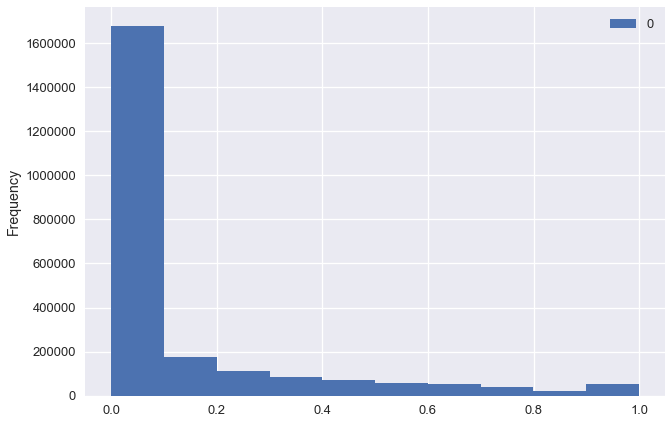

In [28]:
pd.DataFrame(y_test).plot.hist()

In [29]:
print('Test duplicates with >0.9 confidence:', len(df_submission[df_submission.is_duplicate > 0.9]))
print('Test mean prediction:', np.mean(y_test))
print('Calibrated mean prediction:', df_submission['is_duplicate'].mean())

Test duplicates with >0.9 confidence: 42993
Test mean prediction: 0.127606241908
Calibrated mean prediction: 0.07546706870442038


In [30]:
df_submission.to_csv(
    project.submissions_dir + f'{submission_id}-submission-draft-cv-{final_cv_score:.6f}.csv',
    header=True,
    float_format='%.8f',
    index=None,
)